
# LoRaSim2: simulate collisions in LoRa
Extension to the original LoRaSim by Thiemo Voigt <thiemo@sics.se> and Martin Bor <m.bor@lancaster.ac.uk>

This work is licensed under the Creative Commons Attribution 4.0
International License. To view a copy of this license,
visit http://creativecommons.org/licenses/by/4.0/.

In [31]:
# import modules
import simpy
import random
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
import os

## Hardware Sensitivity

Modelling the changes in receiver sensitivity with changes in bandwidth and spreading factor.

These values are derived from Utz's experiments

In [32]:
## Scaled down configuratons for testing purposes
nrBS = 1
avgSendTime = 1200000
simtime = 24*3600*1000 # time in ms

maxNrNodes = 2000
maxNrBS = 1

# define the maximum simulation area
maxX = 10000 # in m
maxY = 10000 # in m

# log shadow model parameters
Ptx = 16 # in dBm
gamma = 2.08
# d0 = 40.0 # in m
d0 = 380 # place-holder value - Adwait
var = 0           # variance ignored for now
# Lpld0 = 127.41
Lpld0 = 109 # place-holder value - Adwait
GL = 0

full_collision = True

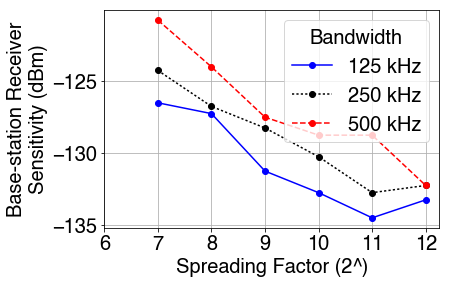

In [33]:
# this is an array with measured values for sensitivity
# see LoRa scaling paper, Table 1
sf7 = np.array([7,-126.5,-124.25,-120.75])
sf8 = np.array([8,-127.25,-126.75,-124.0])
sf9 = np.array([9,-131.25,-128.25,-127.5])
sf10 = np.array([10,-132.75,-130.25,-128.75])
sf11 = np.array([11,-134.5,-132.75,-128.75])
sf12 = np.array([12,-133.25,-132.25,-132.25])

# array of sensitivity values
sensi = np.array([sf7,sf8,sf9,sf10,sf11,sf12])
# sensi = sensi - 11 # correction for changes from 1272 to 1276

# plotting
def plotSensitivity(sensi):
    sensi_fig = plt.figure()

    s125, = plt.plot(sensi[:,0], sensi[:,1],"bo-", label="125 kHz")
    s250, = plt.plot(sensi[:,0], sensi[:,2],"ko:", label="250 kHz")
    s500, = plt.plot(sensi[:,0], sensi[:,3],"ro--", label="500 kHz")

    plt.legend(title="Bandwidth", handles = [s125, s250, s500])
    plt.grid()
    plt.xlabel("Spreading Factor (2^)")
    plt.ylabel("Base-station Receiver\nSensitivity (dBm)")
    plt.xticks([6,7,8,9,10,11,12])

    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.size"] = 20
    plt.show()
    
plotSensitivity(sensi)

## Packet Airtime

Packets of the same size can have varying airtime due to choices of spreading factors and coding rates. The preamble must also be a part of each packet which also adds to the airtime.

The actual formulas cann be seen in the LoRa Design Guide document

**TODO: Add direct formulae from the document**

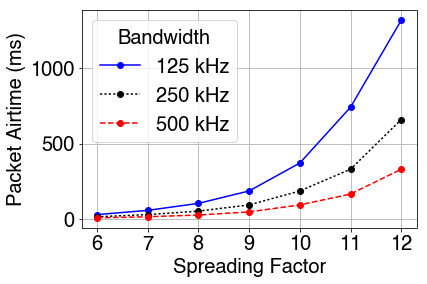

In [34]:
# this function computes the airtime of a packet
# according to LoraDesignGuide_STD.pdf
#
def airtime(sf,cr,pl,bw):
    H = 0        # implicit header disabled (H=0) or not (H=1)
    DE = 0       # low data rate optimization enabled (=1) or not (=0)
    Npream = 8   # number of preamble symbol (12.25  from Utz paper)

    if bw == 125 and sf in [11, 12]:
        # low data rate optimization mandated for BW125 with SF11 and SF12
        DE = 1
    if sf == 6:
        # can only have implicit header with SF6
        H = 1

    Tsym = (2.0**sf)/bw
    Tpream = (Npream + 4.25)*Tsym
    payloadSymbNB = 8 + max(math.ceil((8.0*pl-4.0*sf+28+16-20*H)/(4.0*(sf-2*DE)))*(cr+4),0)
    Tpayload = payloadSymbNB * Tsym
    return Tpream + Tpayload

def plotAirtime():
    
    cr = 1 # fixed coding rate
    pl = 20 # fixed payload length in bytes
    
    bw_list = [125, 250, 500]
    sf_list = [6, 7, 8, 9, 10, 11, 12]
    
    time_in_air = np.zeros((len(bw_list), len(sf_list)))
    
    for i,bw in enumerate(bw_list):
        for j,sf in enumerate(sf_list):
            time_in_air[i,j] = airtime(sf, cr, pl, bw)
            
    airtime_fig = plt.figure()
    
    at125, = plt.plot(sf_list, time_in_air[0,:], "bo-", label="125 kHz")
    at250, = plt.plot(sf_list, time_in_air[1,:], "ko:", label="250 kHz")
    at500, = plt.plot(sf_list, time_in_air[2,:], "ro--", label="500 kHz")

    plt.legend(title="Bandwidth", handles = [at125, at250, at500])
    plt.grid()
    plt.xlabel("Spreading Factor")
    plt.ylabel("Packet Airtime (ms)")
    plt.xticks([6,7,8,9,10,11,12])

    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.size"] = 20
    
    plt.show()
    
plotAirtime()

===== Location generation =====
generated locations for 1 base-stations
generated locations for 2000 nodes


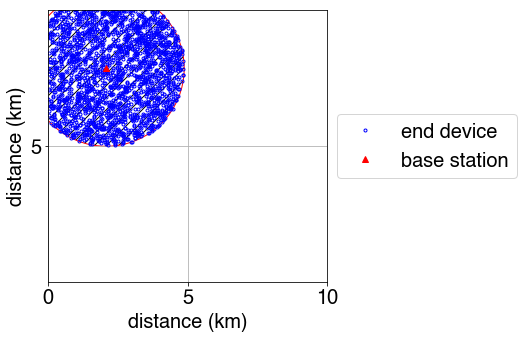

In [35]:
# node placement

Lpl_matrix = Ptx - (sensi[:,1:4])
maxDist = np.dot(d0, np.exp(np.divide((Lpl_matrix - Lpld0),(10*gamma))))
bestDist = np.amax(maxDist)

BSLoc = np.zeros((maxNrBS, 3))
nodeLoc = np.zeros((maxNrNodes, 3))

def placeRandomly(number, locArray, xRange, yRange):
    for n in xrange(number):
        x = random.uniform(xRange[0], xRange[1])
        y = random.uniform(yRange[0], yRange[1])
        locArray[n,:] = [n, x, y]
        
def placeRandomlyInRange(number, locArray, xRange, yRange, refLoc):
    for n in xrange(number):
#         rounds = 0
        while True:
            # This could technically turn into an infinite loop but that shouldn't ever practically happen.
            # add check here later
            x = random.uniform(xRange[0], xRange[1])
            y = random.uniform(yRange[0], yRange[1])
            if np.any(np.sum(np.square(refLoc[:,1:3] - np.array([x,y]).reshape(1,2)), axis=1) <= bestDist**2):
                locArray[n,:] = [n, x, y]
                break
        
print "===== Location generation ====="

random.seed(1)

placeRandomly(maxNrBS, BSLoc, [maxX*0.1, maxX*0.9], [maxY*0.1, maxY*0.9])
print "generated locations for {} base-stations".format(maxNrBS)

placeRandomlyInRange(maxNrNodes, nodeLoc, [0, maxX], [0, maxY], BSLoc)
print "generated locations for {} nodes".format(maxNrNodes)

np.save('bsList_bs8_nodes2000.npy', BSLoc)
np.save('nodesList_bs8_nodes2000.npy', nodeLoc)

def plotLocations():
    loc_plot = plt.figure(figsize = (5,5))
    loc_ax = plt.gca()
    
    bestDist = np.amax(maxDist)
    
    bestDist = np.amax(maxDist)
    for b in BSLoc[:,1:3]:
        loc_ax.add_artist(plt.Circle((b[0], b[1]), bestDist, fill=False, hatch='//', color = 'red'))
    
    nodePoints, = plt.plot(nodeLoc[:,1], nodeLoc[:,2], "b.", mfc='none', label="end device")
    bsPoints, = plt.plot(BSLoc[:,1], BSLoc[:,2], "r^", label="base station")
    
    plt.xticks([0, 5000, 10000, 15000, 20000], [0,5,10,15,20])
    plt.yticks([0, 5000, 10000, 15000, 20000], [0,5,10,15,20])
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    
    plt.axis('equal')
    plt.xlim((0, maxX))
    plt.ylim((0, maxY))
    
    plt.xlabel('distance (km)')
    plt.ylabel('distance (km)')
    
    plt.show()
    
plotLocations()

## Packet Collisions

A number of things determine if 2 or more packets would collide in the air: overlapping spectrum of transmissions, spreading factor leakages, timing collisions etc.

The traditional method of modelling this is using the independent interference model, which checks for the interference between any two packets currently in the air (and not more). This is the method currently used by the original LoRaSim.

Another method is the more complex additive interference model. The next few section will test both of these

In [36]:
# collision checks using the independent interference model
# the collision functions are heavily dependent on the object definitions

#
# check for collisions at base station
# Note: called before a packet (or rather node) is inserted into the list
#
# conditions for collions:
#     1. same sf
#     2. frequency, see function below (Martins email, not implementet yet):
def checkcollision(packet):
    col = 0 # flag needed since there might be several collisions for packet
    # lost packets don't collide
    if packet.lost:
        return 0
    if packetsAtBS[packet.bs]:
        for other in packetsAtBS[packet.bs]:
            if other.id != packet.nodeid:
                # simple collision
                if frequencyCollision(packet, other.packet[packet.bs]) \
                 and sfCollision(packet, other.packet[packet.bs]):
                    if full_collision:
                        if timingCollision(packet, other.packet[packet.bs]):
                            # check who collides in the power domain
                            c = powerCollision(packet, other.packet[packet.bs])
                            # mark all the collided packets
                            # either this one, the other one, or both
                            for p in c:
                                p.collided = 1
                        else:
                            # no timing collision, all fine
                            pass
                    else:
                        packet.collided = 1
                        other.packet[packet.bs].collided = 1  # other also got lost, if it wasn't lost already
                        col = 1
        return col
    return 0

#
# frequencyCollision, conditions
#
#        |f1-f2| <= 120 kHz if f1 or f2 has bw 500
#        |f1-f2| <= 60 kHz if f1 or f2 has bw 250
#        |f1-f2| <= 30 kHz if f1 or f2 has bw 125
def frequencyCollision(p1,p2):
    if (abs(p1.freq-p2.freq)<=120 and (p1.bw==500 or p2.freq==500)):
        return True
    elif (abs(p1.freq-p2.freq)<=60 and (p1.bw==250 or p2.freq==250)):
        return True
    else:
        if (abs(p1.freq-p2.freq)<=30):
            return True
    return False

def sfCollision(p1, p2):
    if p1.sf == p2.sf:
        # p2 may have been lost too, will be marked by other checks
        return True
    return False

def powerCollision(p1, p2):
    powerThreshold = 6 # dB
    if abs(p1.rssi - p2.rssi) < powerThreshold:
        # packets are too close to each other, both collide
        # return both packets as casualties
        return (p1, p2)
    elif p1.rssi - p2.rssi < powerThreshold:
        # p2 overpowered p1, return p1 as casualty
        return (p1,)
    # p2 was the weaker packet, return it as a casualty
    return (p2,)

def timingCollision(p1, p2):
    # assuming p1 is the freshly arrived packet and this is the last check
    # we've already determined that p1 is a weak packet, so the only
    # way we can win is by being late enough (only the first n - 5 preamble symbols overlap)

    # assuming 8 preamble symbols
    Npream = 8

    # we can lose at most (Npream - 5) * Tsym of our preamble
    Tpreamb = 2**p1.sf/(1.0*p1.bw) * (Npream - 5)

    # check whether p2 ends in p1's critical section
    p2_end = p2.addTime + p2.rectime
    p1_cs = env.now + Tpreamb
    if p1_cs < p2_end:
        # p1 collided with p2 and lost
        return True
    return False

# this function computes the airtime of a packet
# according to LoraDesignGuide_STD.pdf
#
def airtime(sf,cr,pl,bw):
    H = 0        # implicit header disabled (H=0) or not (H=1)
    DE = 0       # low data rate optimization enabled (=1) or not (=0)
    Npream = 8   # number of preamble symbol (12.25  from Utz paper)

    if bw == 125 and sf in [11, 12]:
        # low data rate optimization mandated for BW125 with SF11 and SF12
        DE = 1
    if sf == 6:
        # can only have implicit header with SF6
        H = 1

    Tsym = (2.0**sf)/bw
    Tpream = (Npream + 4.25)*Tsym
    payloadSymbNB = 8 + max(math.ceil((8.0*pl-4.0*sf+28+16-20*H)/(4.0*(sf-2*DE)))*(cr+4),0)
    Tpayload = payloadSymbNB * Tsym
    return Tpream + Tpayload

#
# this function creates a BS
#
class myBS():
    def __init__(self, id, position):
        self.id = id
        self.x, self.y = position

#
# this function creates a node
#
class myNode():
    def __init__(self, id, position, period, packetlen):
        global bs

        self.id = id
        self.period = period
        self.x, self.y = position
        self.packet = []
        self.dist = []
        
        self.f, self.bw, self. sf, self.cr = self.getTransmissionParams()
        
        # create "virtual" packet for each BS
        global nrBS
        for i in range(0,nrBS):
            d = np.sqrt((self.x-bs[i].x)*(self.x-bs[i].x)+(self.y-bs[i].y)*(self.y-bs[i].y))
            self.dist.append(d)
            self.packet.append(myPacket(self.id, packetlen, self.dist[i], self.f, i, self.sf, self.cr, self.bw))

        self.sent = 0
        
    def getTransmissionParams(self):
        # this function currently returns fixed parameters
        freq = 902.3
        bw = 125
        sf = 11
        cr = 1
        return freq, bw, sf, cr
    
    def updateTransmissionParams(self):
        # use this function to create a hopping node
        pass

#
# this function creates a packet (associated with a node)
# it also sets all parameters, currently random
#
class myPacket():
    def __init__(self, nodeid, plen, distance, freq, bs, sf, cr, bw):
        global experiment
        global Ptx
        global gamma
        global d0
        global var
        global Lpld0
        global GL
        global sensi


        # new: base station ID
        self.bs = bs
        self.nodeid = nodeid
        
        # randomize configuration values
        self.sf = sf
        self.cr = cr
        self.bw = bw

        # log-shadow
        # note: transmit power is global variable
        Lpl = Lpld0 + 10*gamma*math.log(distance/d0)
#         print Lpl
        Prx = Ptx - GL - Lpl

        # transmission range, needs update XXX
        self.transRange = 150
        self.pl = plen
        self.symTime = (2.0**self.sf)/self.bw
        self.arriveTime = 0
        self.rssi = Prx
        self.freq = freq

        self.rectime = airtime(self.sf,self.cr,self.pl,self.bw)
        # denote if packet is collided
        self.collided = 0
        self.processed = 0

        packet_sensitivity = sensi[sf - 7, int(bw // 250) + 1]
        self.lost = self.rssi < packet_sensitivity
#         if self.lost:
#             print "node {} bs {} lost (rssi = {} < sensi = {})".format(self.nodeid, self.bs, self.rssi, packet_sensitivity)


#
# main discrete event loop, runs for each node
# a global list of packet being processed at the gateway
# is maintained
#
def transmit(env,node):
    
    global packetSeq
    global nrBS
    global nrLost
    global nrTransmitted
    global nrReceived
    global nrCollisions
    
    while True:
        yield env.timeout(random.expovariate(1.0/float(node.period)))

        # time sending and receiving
        # packet arrives -> add to base station

        node.sent = node.sent + 1
        
        packetSeq = packetSeq + 1

        for bs in range(0, nrBS):
            if (node in packetsAtBS[bs]):
                print "ERROR: packet already in"
            else:
                # adding packet if no collision
                if (checkcollision(node.packet[bs])==1):
                    node.packet[bs].collided = 1
                else:
                    node.packet[bs].collided = 0
                packetsAtBS[bs].append(node)
                node.packet[bs].addTime = env.now
                node.packet[bs].seqNr = packetSeq

        # take first packet rectime
        yield env.timeout(node.packet[0].rectime)
        
        nrTransmitted += 1

        # if packet did not collide, add it in list of received packets
        # unless it is already in
        
        packetLostFlag = True
        collisionFlag = False
        for bs in range(0, nrBS):
            if node.packet[bs].lost:
                lostPackets.append(node.packet[bs].seqNr)
            else:
                if node.packet[bs].collided == 0:
                    packetLostFlag = False
                    packetsRecBS[bs].append(node.packet[bs].seqNr)
                    if (recPackets):
                        if (recPackets[-1] != node.packet[bs].seqNr):
                            recPackets.append(node.packet[bs].seqNr)
                    else:
                        recPackets.append(node.packet[bs].seqNr)
                else:
                    # XXX only for debugging
                    collidedPackets.append(node.packet[bs].seqNr)
                    collisionFlag = True
                    
        if packetLostFlag:
            nrLost += 1
        else:
            nrReceived += 1
            
        if collisionFlag:
            nrCollisions += 1
            
        # complete packet has been received by base station
        # can remove it
        for bs in range(0, nrBS):
            if (node in packetsAtBS[bs]):
                packetsAtBS[bs].remove(node)
                # reset the packet
                node.packet[bs].collided = 0
                node.packet[bs].processed = 0

In [37]:
simSetting = list(np.linspace(100,2000,20,endpoint = True, dtype=int))

totalTransmitted = []
totalLost = []
totalReceived = []
totalCollided = []

for i,n in enumerate(simSetting):
    # global stuff
    nrNodes = n
    nodes = []
    bs = []
    packetsAtBS = []
    packetsRecBS = []

    env = simpy.Environment()


    # max distance: 300m in city, 3000 m outside (5 km Utz experiment)
    # also more unit-disc like according to Utz
    nrLost = 0
    nrCollisions = 0
    nrReceived = 0
    nrTransmitted = 0

    # global value of packet sequence numbers
    packetSeq = 0

    # list of received packets
    recPackets=[]
    collidedPackets=[]
    lostPackets = []

    # some feedback on what's going on

    print "===== Setup parameters ====="
    print "grid size = {} m x {} m".format(maxX, maxY)
    print "# base-stations = {}".format(nrBS)
    print "# nodes = {}".format(nrNodes)
    print "minimum sensitivity (dBm) = {}".format(np.amin(sensi))
    np.set_printoptions(precision=2, suppress=True)
    print "calculated max transmission distance (m) =\n{}".format(maxDist)

    ## create all the base-stations

    for b_loc in BSLoc:
        b = myBS(int(b_loc[0]), (b_loc[1], b_loc[2]))
        bs.append(b)
        packetsAtBS.append([])
        packetsRecBS.append([])
    
    for node_loc in nodeLoc[0:nrNodes, :]:
        n = myNode(int(node_loc[0]), (node_loc[1], node_loc[2]), avgSendTime, 20) # send a packet of 20 bytes every 20 min
        nodes.append(n)
        env.process(transmit(env, n))

    print "===== simulation objects created ====="

    env.run(until=simtime)

    # print "nr received packets", len(recPackets)
    # print "nr collided packets", len(collidedPackets)
    # print "nr lost packets", len(lostPackets)

    print "# transmitted = {}".format(nrTransmitted)
    print "# received = {}".format(nrReceived)
    print "# lost = {}".format(nrLost)
    print "# collisions = {}".format(int(nrCollisions))
    
    totalTransmitted.append(nrTransmitted)
    totalReceived.append(nrReceived)
    totalLost.append(nrLost)
    totalCollided.append(nrCollisions)
    
print "nodes: {}".format(simSetting)
print "Transmitted: {}".format(totalTransmitted)
print "Received: {}".format(totalReceived)
print "Collisions: {}".format(totalCollided)

===== Setup parameters =====
grid size = 10000 m x 10000 m
# base-stations = 1
# nodes = 100
minimum sensitivity (dBm) = -134.5
calculated max transmission distance (m) =
[[ 1902.17  1707.14  1442.75]
 [ 1972.    1925.17  1686.74]
 [ 2390.16  2069.13  1995.85]
 [ 2568.89  2277.96  2119.47]
 [ 2794.37  2568.89  2119.47]
 [ 2631.39  2507.87  2507.87]]
===== simulation objects created =====
# transmitted = 7172
# received = 6896
# lost = 276
# collisions = 276
===== Setup parameters =====
grid size = 10000 m x 10000 m
# base-stations = 1
# nodes = 200
minimum sensitivity (dBm) = -134.5
calculated max transmission distance (m) =
[[ 1902.17  1707.14  1442.75]
 [ 1972.    1925.17  1686.74]
 [ 2390.16  2069.13  1995.85]
 [ 2568.89  2277.96  2119.47]
 [ 2794.37  2568.89  2119.47]
 [ 2631.39  2507.87  2507.87]]
===== simulation objects created =====
# transmitted = 14278
# received = 13166
# lost = 1112
# collisions = 1112
===== Setup parameters =====
grid size = 10000 m x 10000 m
# base-statio

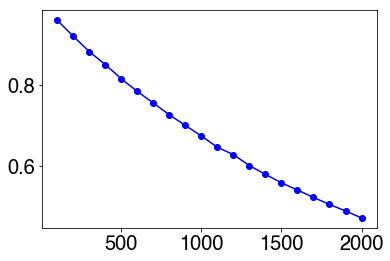

In [38]:

def plotIIMPacketReception():
    
#     print totalReceived
#     print totalTransmitted
    
#     print np.divide(np.array(totalReceived, dtype=float), np.array(totalTransmitted, dtype=float))

    iimDerPlot = plt.figure()
    plt.plot(simSetting, np.divide(np.array(totalReceived, dtype=float), np.array(totalTransmitted, dtype=float)), 'bo-')
    plt.show()
    
plotIIMPacketReception()

In [59]:
def getFreqBucketsFromSet(BSFreqSetList):
    ## This function gives a list of frequencies for various bandwidths used by our basestations
    ## This is only applicable to the US 902-928 specifications.
    ## Other regions would need their own functions
    
    
    freqSetList = np.unique(BSFreqSetList)
#     freq125 = np.array([], dtype=int)
#     freq500 = np.array([],dtype=int)
    freq125 = set()
    freq500 = set()
    for i in freqSetList:
        freq125.update(np.linspace(902300 + 200*8*i, 903700 + 200*8*i, 8, dtype=int))
        freq500.add(903000 + 1600*i)

    return freq125,freq500

class myBS_AIM():
    def __init__(self, bsid, position, BSFreqSetList = []):
        self.bsid = bsid
        self.x, self.y = position
        self.packetsAtBS = []
        
        if BSFreqSetList:
            # non empty list provided
            self.freqSetList = BSFreqSetList
        else:
            self.freqSetList = getRandomFreqSet()
            
        # RX frequencies are stored as a set for easy searching later
        self.RXFreq125, self.RXFreq500 = getFreqBucketsFromSet(self.freqSetList)
        
    def getRandomFreqSet(self):
        return random.randint(0,7)
        
    def updateRXFreqSet(self, BSFreqSetList):
        self.RXFreq125, self.RXFreq500 = getFreqBucketsFromSet(BSFreqSetList)
        
    
class myNode_AIM():
    def __init__(self, nodeid, position):
        self.nodeid = nodeid
        self.x, self.y = position
    
class myPacket_AIM():
    def __init__(self):
        pass

125: set([909900, 912500, 906500, 907100, 902700, 909700, 912300, 905100, 912100, 909500, 903700, 910300, 914700, 908500, 903300, 902300, 909300, 911900, 914500, 904100, 911300, 909100, 911700, 905500, 905900, 908900, 911500, 914100, 904500, 910700, 902900, 908700, 906300, 913900, 914900, 904900, 911100, 913700, 906700, 914300, 903500, 908300, 910900, 913500, 905300, 908100, 905700, 913300, 903900, 907900, 910500, 902500, 903100, 907700, 904300, 912900, 913100, 906100, 907500, 910100, 912700, 906900, 904700, 907300]), 500: set([907800, 911000, 914200, 904600, 906200, 909400, 903000, 912600])
